## Unconditional Diffusion Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from typing import List, Dict, Tuple, Set, Union, Optional, Any, Callable

os.chdir('/scratch/x2895a03/research/md-diffusion/Ashesh')

In [2]:
import ase

In [3]:
temperature = 200

#uncond=np.load(f'./results/Diffusion_MD_trial_egnn_3lr_3e-4_t250_1000_{temperature}K.npz')

exp_name = "Diffusion_MD_trial_egnn_3lr_1e-4_t250_200K_ pbc_fixed_501"
uncond = np.load(f'./results/{exp_name}.npz')

In [4]:
uncond.files

['pred', 'GT']

In [5]:
print(uncond['pred'].shape)
uncond_pre = np.mean(uncond['pred'], axis=1)
print(uncond_pre.shape)
# uncond_pre = uncond['pred'][:, :, 1, :, :, :  ] * 25

(15000, 1, 10, 1, 64, 9)
(15000, 10, 1, 64, 9)


(100, 150, 10, 1, 64)


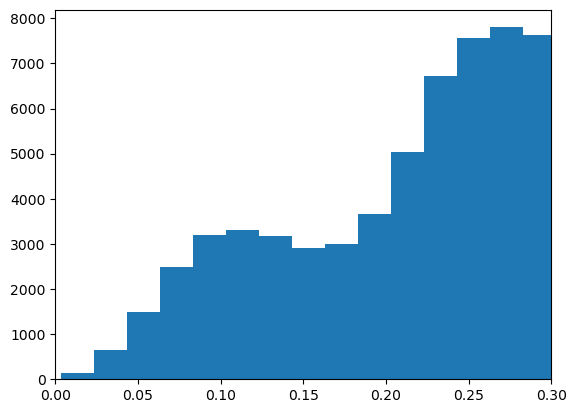

In [6]:
# extract valocities and chunk 
vels = uncond_pre[..., -3:] 
n_chunks = 100
vels = np.array_split(vels, n_chunks, axis=0)

# magnitude of velocity
vels_mag = np.linalg.norm(vels, axis=-1)
print(vels_mag.shape)
vels_mag = np.reshape(vels_mag, (n_chunks, -1))

plt.hist(vels_mag[88], bins=100)
plt.xlim(0, 0.3)
plt.show()

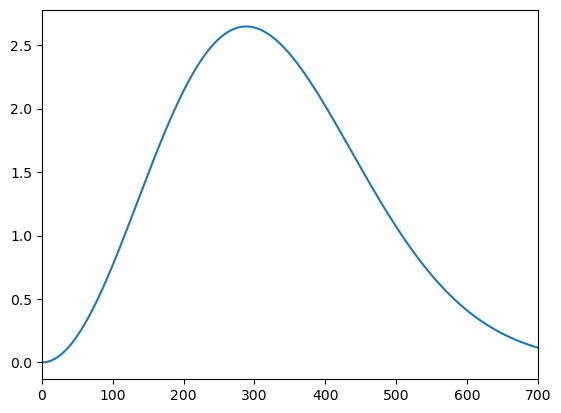

In [19]:
# plot maxwell-boltzmann distribution
v_max = 700
v = np.linspace(0, v_max, 10000)
m = 40 * 1.66053906660e-27
T = temperature
k = 1.38064852e-23
f = v**2 * np.sqrt(m / (2 * np.pi * k * T))**(3/2) * np.exp(-m * v**2 / (2 * k * T))
plt.plot(v, f)
plt.xlim(0, v_max)
plt.show()

In [20]:
uncond_gt = uncond['GT']
print(uncond_gt.shape)

(12800, 1, 64, 9)


In [21]:
xyzs = uncond_gt[..., :3] 
print(np.max(xyzs), np.min(xyzs))

72.58371084173643 -50.09448042865341


(10, 1280, 1, 64)
(100, 150, 10, 1, 64)


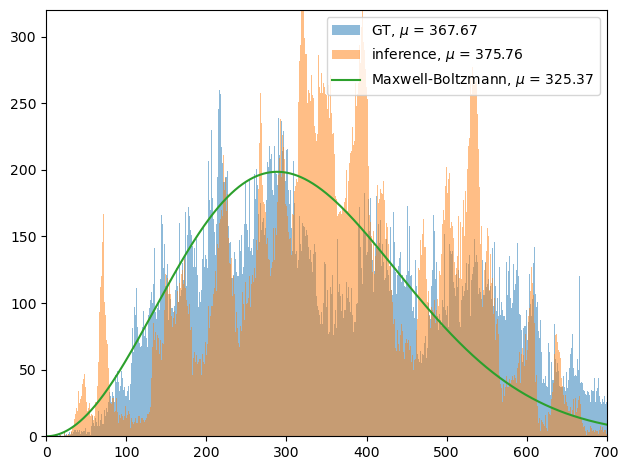

In [22]:
# extract valocities and chunk 
vels_GT = uncond_gt[..., -3:] * 10000
n_chunks = 10
vels_GT = np.array_split(vels_GT, n_chunks, axis=0)

# magnitude of velocity(GT)
vels_mag_GT = np.linalg.norm(vels_GT, axis=-1)
print(vels_mag_GT.shape)
vels_mag_GT = np.reshape(vels_mag_GT, (n_chunks, -1))


vels = uncond_pre[..., -3:] * 10000
vels = np.array_split(vels, n_chunks*10, axis=0)
# magnitude of velocity(inference)
vels_mag = np.linalg.norm(vels, axis=-1)
print(vels_mag.shape)
vels_mag = np.reshape(vels_mag, (n_chunks*10, -1))

vel_to_plot_GT = vels_mag_GT[9]
vel_to_plot = vels_mag[13]


plt.hist(vel_to_plot_GT, bins=1000, alpha=0.5, label=f'GT, $\mu$ = {np.mean(vel_to_plot_GT):.2f}')
plt.hist(vel_to_plot, bins=1000, alpha=0.5, label=f'inference, $\mu$ = {np.mean(vel_to_plot):.2f}')
plt.plot(v, f * 75, label=f'Maxwell-Boltzmann, $\mu$ = {2 * np.sqrt((2 * k * T) / m / np.pi):.2f}')
plt.xlim(0, v_max)
plt.ylim(0, 320)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# check is nan
print(np.isnan(vel_to_plot).any())
print(vel_to_plot.shape)
print("mas and min", np.max(vel_to_plot), np.min(vel_to_plot))
print(vel_to_plot[:100], vel_to_plot_GT[-100:])

False
(96000,)
mas and min 805.6930509396187 17.14120074384106
[314.59939473 277.92886768 390.38091013 375.91858184 132.52180362
 266.47611908 728.60306458 534.73489142 321.7812209  551.78831948
 532.77121664 150.09406043 498.5087457  278.553107   605.90025687
 167.9512305  336.12617471 202.82601109 308.32460078 316.21829751
  67.89894522 380.33557537 432.16320308 143.88871407 295.38235497
 425.42737778 386.33415619 589.09131191 303.21059181 455.16413366
 439.6706057  491.55719266 146.98488837 424.44644699 330.55113381
 636.90607159 295.79078658 230.99476433 237.37533999 177.34232136
 517.91173195 503.28789363 572.71464324 380.63142102 290.71460696
 153.74501367 547.49715763 526.00245787  43.63332868 271.94208452
 336.15739091 403.17506378 388.21939317 309.63968514 357.58823946
 436.92196843 576.81171286 573.38114009 472.5506002  163.31741207
 464.2611498  411.76845598 769.68570344 248.55356849 320.27116517
 274.55407815 379.03742191 369.58504964 138.36910124 267.70372823
 738.07920665

In [24]:
np.shape(uncond_pre), np.shape(uncond_gt)

((15000, 10, 1, 64, 9), (12800, 1, 64, 9))

In [30]:
#uncond_pre = np.mean(uncond_pre, 2)

In [24]:
print(np.shape(uncond_pre))
print(np.shape(uncond_gt))

(15000, 10, 1, 64, 9)
(12800, 1, 64, 9)


In [26]:
#uncond_pre = np.mean(uncond_pre, 1)
print(uncond_pre.shape)
from tqdm import tqdm

(15000, 10, 1, 64, 9)


In [27]:
d1, d2, d3, d4 = np.shape(uncond_gt) # 512 1 64 9
print(d1, d2, d3, d4)
n_frames_to_draw = 200

for trajs in range(1):
    # if os.path.exists("./results/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png"):
    #     continue
    for idx in tqdm(range(200)):
        idx = 12000 + idx * 10
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        if idx < d1:
            for i in range(d3):
                if i == d3 -1:
                    ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black', label="GT")
                else:    
                    ax.scatter(uncond_gt[idx,0,i,0],uncond_gt[idx,0,i,1],uncond_gt[idx,0,i,2], marker='o', c='black')
        for i in range(d3):
            if i == d3 -1:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red', label="Pre")
            else:
                ax.scatter(uncond_pre[idx,trajs,0,i,0],uncond_pre[idx,trajs,0,i,1],uncond_pre[idx,trajs,0,i,2], marker='*', c='red')

        ax.set_title('Test trajectory #'+str(trajs)+',  t = #'+str(idx))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.savefig("./results/extrapolate/long_diffusion_test_point_#"+str(idx)+"_traj_#"+str(trajs)+".png")    
        plt.close()

12800 1 64 9


100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


In [29]:
# generate gif with saved figs
import imageio
n_frames_to_draw = 200
with imageio.get_writer('./results/long_diffusion_12000_14000_200K.gif', mode='I') as writer:
    for filename in ["./results/extrapolate/long_diffusion_test_point_#"+str(12000 + idx * 10)+"_traj_#0"+".png" \
    for idx in range(n_frames_to_draw)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_76106/3751838024.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# GT data

In [7]:
dataset_path = "dataset"
x_tensor=np.load(os.path.join(dataset_path, "input_long_200K.npy"))
x_tensor = np.reshape(x_tensor, (-1,  64, 9))
print(x_tensor.shape)

(100000, 64, 9)


In [8]:
### DONT EXECUTE THIS PART 
import imageio
# Generate figure for the first 10k frames with stride 4
for idx in range(500):
    idx = idx * 100 
    if os.path.exists("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png"):
        continue

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for i in range(64):
        if i == 63:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black', label="GT")
        else:
            ax.scatter(x_tensor[idx,i,0],x_tensor[idx,i,1],x_tensor[idx,i,2], marker='o', c='black')
    ax.set_title('GT trajectory,  t = #'+str(idx))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    if not os.path.exists("./results/GT_figs"):
        os.makedirs("./results/GT_figs")
    plt.savefig("./results/GT_figs/diffusion_gt_test_point_#"+str(idx)+".png")    
    plt.close()

# generate gif with saved figs
with imageio.get_writer('./results/GT_start.gif', mode='I') as writer:
    for filename in ["./results/GT_figs/diffusion_gt_test_point_#"+str(idx * 100)+".png" for idx in range(500)]:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_24507/3005087242.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [12]:
x_tensor[0].shape

(64, 9)

In [16]:
def pbc_coord(coord: torch.Tensor, lattice: torch.Tensor) -> torch.Tensor:
    """
    Apply periodic boundary condition to the coordinates.
    Args:
        coord (torch.Tensor): The coordinates to apply PBC to. The shape is (batch_size, num_atoms, 3).
        lattice (torch.Tensor): The lattice vectors. The shape is (batch_size, 3, 3).
    Returns:
        torch.Tensor: The coordinates after applying PBC. The shape is (batch_size, num_atoms, 3).
    """
    # Calculate the fractional coordinates
    fractional_coord = torch.einsum('bji,bni->bnj', torch.inverse(lattice), coord)
    # Apply PBC
    fractional_coord = fractional_coord - torch.round(fractional_coord)
    # Convert back to Cartesian coordinates
    coord = torch.einsum('bji,bnj->bni', lattice, fractional_coord)
    return coord

def compute_min_distance_pbc_single_cell(
                    coord1: torch.Tensor,  # (batch, num_atom, 3)
                    coord2: torch.Tensor,  # (batch, num_atom, 3)
                    lattice1: torch.Tensor,  # (batch, 3, 3) lattice vectors for coord1 (GT)
                    lattice2: torch.Tensor,  # (batch, 3, 3) optional lattice for coord2 (Pred)
                    mask: torch.Tensor,
                    cutoff: float = 5,
                    eps: float = 1e-6,
                    return_disp: bool = False,
                    num_image_cell: int = 1) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
    
    if lattice1 is None and lattice2 is None:
        return comput_disp(coord1, coord2, mask, cutoff, eps)

    #print("coord shape: ", coord1.shape)
    batch_size, num_atoms, _ = coord1.shape
    # Normalize the coord (move into the unit cell)
    #print('coord before pbc_coord: ', coord)
    #coord = pbc_coord(coord, lattice)
    #print('coord after pbc_coord: ', coord)
    # if self.max_neighbor is not None:
    # Step 1: Generate relative cell displacement vectors
    # num_image_cell:1 -> (3x3x3) shift vectors
    # num_image_cell:3 -> (7x7x7) shift vectors
    # n_img == num_image_cell**3
    # print("lattice and coord shape : ", lattice1.shape, coord1.shape)

    # step 1: Generate relative cell displacement vectors
    shifts = torch.stack(torch.meshgrid(
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in x
        torch.arange(-num_image_cell, num_image_cell + 1),  # Neighbor cells in y
        torch.arange(-num_image_cell, num_image_cell + 1),   # Neighbor cells in z
    indexing="ij"), dim=-1).reshape(-1, 3).type(coord1.dtype).to(coord1.device)  
    # shift = [0,0,0] index
    r_000_index = torch.where(torch.all(shifts == 0, dim=-1))[0].item()
    num_images = shifts.shape[0]
    # Apply lattice vectors to get Cartesian displacements for the 27 neighbor cells
    # The shape should be (batch_size, 27, 3), where lattice has shape (batch_size, 3, 3) and shifts has shape (27, 3)
    # print("shifts shape: ", shifts.shape)
    r_vector_1 = torch.einsum('nj, bji->bni', shifts, lattice1)  # (batch_size, 27, 3)
    r_vector_2 = torch.einsum('nj, bji->bni', shifts, lattice2)
    # print("r_vector shape: ", r_vector.shape)
        
    # Step 2: calculate distance btw original(coord1) and noised coord pbc (coord2_ext)
    # coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    coord1_ext = coord1.unsqueeze(2) + r_vector_1.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_1 = coord1_ext.unsqueeze(2) - coord1.unsqueeze(1).unsqueeze(3)
    coord2_ext = coord2.unsqueeze(2) + r_vector_2.unsqueeze(1)  # (batch_size, num_atoms, n_img, 3)
    disp_2 = coord2_ext.unsqueeze(2) - coord2.unsqueeze(1).unsqueeze(3)
    
    
    self_min_disp = torch.sqrt(torch.sum(disp_1 ** 2, dim=-1))  # (batch_size, num_atoms, num_atoms, n_img)
    
    #print("self min disp shape: ", self_min_disp.shape)

    min_dist, min_idx = torch.min(self_min_disp, dim=-1)  # (batch_size, num_atoms, num_atoms)
    min_disp = torch.gather(disp_1, 3,  min_idx.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, 1, 3))
    
    #return disp
    return min_dist, min_disp, min_idx


device ="cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
cell_vector = torch.tensor([[[21.04, 0.0, 0.0], [0.0, 21.04, 0.0], [0.0, 0.0, 21.04]]], device=device)
coord1 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
coord2 = torch.from_numpy(x_tensor[1000:1002, :, :3]).to(device).float()
min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
    compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
print(min_disp_single_cell.shape)

torch.Size([2, 64, 64, 1, 3])


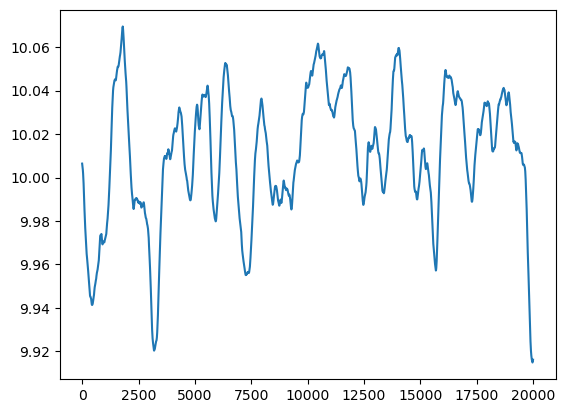

In [14]:
vec_difference = []
for i in range(5000, 25000):
    coord1 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord1 = pbc_coord(coord1, cell_vector)
    coord2 = torch.from_numpy(x_tensor[i:i+1, :, :3]).to(device).float()
    coord2 = pbc_coord(coord2, cell_vector)
    min_dist_single_cell, min_disp_single_cell, min_idx_single_cell = \
        compute_min_distance_pbc_single_cell(coord1, coord2, cell_vector, cell_vector, mask=None)
    vec_difference.append(np.mean(min_dist_single_cell.cpu().detach().numpy()))

plt.plot(vec_difference)

In [11]:
min_dist_single_cell.shape

torch.Size([2, 64, 64])

In [17]:
coord1_pbc = pbc_coord(coord1, cell_vector)
print(coord1_pbc)

tensor([[[  1.0201,   1.9814,  -6.0188],
         [ -2.4328,  -2.1128,  -4.4550],
         [ -0.1289,   0.3778,   2.4622],
         [  1.1462,  -1.6272,  -4.8529],
         [ -5.4636,   4.3570,   1.6906],
         [  0.0815,   7.7222,   9.9612],
         [  6.8912,   0.0584, -10.4754],
         [  5.1695,   3.6115,  -9.8377],
         [ -2.8163,   7.1847,   1.2407],
         [  9.1299,  -7.9799,  -3.2584],
         [ -2.9740,   8.0036,   7.2613],
         [ -1.1984,  -7.4684,  -0.9964],
         [ -0.6014,  -4.1785,  -0.3202],
         [ -3.5899,  -7.6070,   3.2005],
         [  3.6976,  -4.4608,   8.0617],
         [ -1.4569,  -9.7679,   7.1971],
         [  7.9639,   1.9626,   1.2257],
         [  7.8107,   3.4569,   8.7944],
         [  8.8347,   2.9067,  -8.6647],
         [  4.2086,  -2.0946,  -8.1934],
         [ -0.1261,   6.5052,   4.5021],
         [  4.2660,   8.6567, -10.1287],
         [  3.8450,   4.4254,   7.2449],
         [  8.5897,   6.0888,  -0.3927],
         [  1.59

In [72]:
torch.sqrt(torch.sum(min_disp_single_cell.squeeze()**2, -1))

tensor([[ 0.0000,  6.4037,  3.8313,  ...,  8.8433, 10.2151, 11.9957],
        [ 6.4037,  0.0000,  8.9623,  ..., 11.9629, 10.6630, 14.6291],
        [ 3.8313,  8.9623,  0.0000,  ...,  5.3643,  6.4464, 10.3749],
        ...,
        [ 8.8433, 11.9629,  5.3643,  ...,  0.0000,  4.6452,  5.4114],
        [10.2151, 10.6630,  6.4464,  ...,  4.6452,  0.0000,  6.9678],
        [11.9957, 14.6291, 10.3749,  ...,  5.4114,  6.9678,  0.0000]])

## Model Sanity Check

In [18]:
from models.EGNN import * 
model = EGNN(in_dim=64,
            out_dim=9, # coord, force, vel output
            h_dim=128,
            num_layer=3,
            num_timesteps=250,
            update_coord='last',
            use_attention=True,
            num_head=4,
            use_condition=True,
            temperature=200)

In [22]:
test_frane = torch.from_numpy(uncond_gt[0]).float()
test_coord = torch.from_numpy(uncond_gt[0][:, :, :3]).float()
rotation_matrix = torch.tensor([[1, 0, 0], [0, 0, 1], [0, -1, 0]] ).float() # 90 degree rotation around x-axis
rotation_matrix_inverse = torch.inverse(rotation_matrix)
test_coord_rotate = torch.matmul(test_coord, rotation_matrix)
test_coord_translate = test_coord + 10

test_coord_pbc = pbc_coord(test_coord, cell_vector)
test_coord_rotate_pbc = pbc_coord(test_coord_rotate, cell_vector)

# 1. check min distances
min_dist_test, min_disp_test, min_idx_test = \
    compute_min_distance_pbc_single_cell(test_coord, test_coord, cell_vector, cell_vector, mask=None)
min_dist_test_rotate, min_disp_test_rotate, min_idx_test_rotate = \
    compute_min_distance_pbc_single_cell(test_coord_rotate, test_coord_rotate, cell_vector, cell_vector, mask=None)
min_dist_test_translate, min_disp_test_translate, min_idx_test_translate = \
    compute_min_distance_pbc_single_cell(test_coord_translate, test_coord_translate, cell_vector, cell_vector, mask=None)

In [23]:
print("difference btw raw and rotated : ", torch.sum((min_dist_test - min_dist_test_rotate)**2))
print("difference btw raw and translated : ", torch.sum((min_dist_test - min_dist_test_translate)**2))

difference btw raw and rotated :  tensor(1.1383e-09)
difference btw raw and translated :  tensor(6.5359e-09)


In [24]:
print(min_disp_test_rotate.shape)

torch.Size([1, 64, 64, 1, 3])


In [25]:
# 2. check displacements
min_disp_test_rotate_inverse = torch.matmul(min_disp_test_rotate, rotation_matrix_inverse)
print(min_disp_test_rotate_inverse.shape)
print("difference btw raw and rotated : ", torch.sum((min_disp_test - min_disp_test_rotate_inverse)**2))
print("difference btw raw and translated : ", torch.sum((min_disp_test - min_disp_test_translate)**2))

torch.Size([1, 64, 64, 1, 3])
difference btw raw and rotated :  tensor(0.)
difference btw raw and translated :  tensor(1.5182e-08)


In [26]:
# 3. check model outputs
n_frames, n_atoms, n_features = test_frane.shape
mask = torch.ones((n_frames, n_atoms))

mask2d_test = min_dist_test < 10.0
mask2d_test_rotate = min_dist_test_rotate < 10.0
mask2d_test_translate = min_dist_test_translate < 10.0
t = torch.tensor([[0.0]])

x_force_speed_test = torch.from_numpy(uncond_gt[0][:, :, 3:]).float()
x_0_test = torch.cat([test_coord, x_force_speed_test], dim=-1)
print(x_0_test.shape)
# orig outputs
feat_noise_pred, coord_noise_pred = model(x_force_speed_test, test_coord_pbc, min_dist_test, min_disp_test, t.view(-1, 1), 
                                                adj_mat=mask2d_test, mask=mask, mask2d=mask2d_test, condition=x_0_test)
# rotated outputs
feat_noise_pred_rotate, coord_noise_pred_rotate = model(x_force_speed_test, test_coord_rotate_pbc, min_dist_test_rotate, min_disp_test_rotate, t.view(-1, 1),
                                                adj_mat=mask2d_test_rotate, mask=mask, mask2d=mask2d_test_rotate, condition=x_0_test)
# translated outputs
feat_noise_pred_translate, coord_noise_pred_translate = model(x_force_speed_test, test_coord_translate, min_dist_test_translate, min_disp_test_translate, t.view(-1, 1),
                                                adj_mat=mask2d_test_translate, mask=mask, mask2d=mask2d_test_translate, condition=x_0_test)
                                                

torch.Size([1, 64, 9])


In [27]:
# coord noise difference
print("difference btw raw and rotated : ", torch.sum((coord_noise_pred - coord_noise_pred_rotate)**2))
print("difference btw raw and translated : ", torch.sum((coord_noise_pred - coord_noise_pred_translate)**2))

# feat noise difference
print("difference btw raw and rotated : ", torch.sum((feat_noise_pred - feat_noise_pred_rotate)**2))
print("difference btw raw and translated : ", torch.sum((feat_noise_pred - feat_noise_pred_translate)**2))

difference btw raw and rotated :  tensor(0.0038, grad_fn=<SumBackward0>)
difference btw raw and translated :  tensor(2.6604e-15, grad_fn=<SumBackward0>)
difference btw raw and rotated :  tensor(1.1336e-14, grad_fn=<SumBackward0>)
difference btw raw and translated :  tensor(1.2262e-14, grad_fn=<SumBackward0>)


In [28]:
print(torch.sum(mask2d_test))
print(torch.sum(mask2d_test_rotate))
print(torch.sum(mask2d_test_translate))

tensor(1142)
tensor(1142)
tensor(1142)


In [46]:
print(coord_noise_pred_rotate)

tensor([[[ 1.2038e-03,  3.7955e-03,  1.2686e-02],
         [-1.3618e-03,  8.7129e-03,  8.5755e-04],
         [-7.3988e-03, -2.6443e-04, -5.0469e-03],
         [-1.5771e-03,  8.4007e-03,  4.8167e-03],
         [ 3.9450e-03,  1.4515e-03, -4.2162e-03],
         [-2.0340e-03,  8.3611e-03, -1.9170e-02],
         [-9.5305e-03,  7.0856e-03,  2.8216e-03],
         [-2.1621e-03, -4.9054e-03,  1.2577e-03],
         [-3.4072e-03,  1.7927e-03, -2.7197e-03],
         [-6.5046e-03, -9.4576e-03,  4.1625e-03],
         [-2.0390e-03, -1.7764e-03,  3.0300e-03],
         [ 7.3442e-03,  2.9610e-03,  1.2968e-02],
         [ 5.0262e-03, -2.8118e-03,  3.5831e-03],
         [ 1.0741e-02,  4.2860e-03, -2.7055e-03],
         [-7.1461e-03,  7.0708e-03,  4.6744e-03],
         [ 1.3679e-02, -4.3140e-04,  4.9045e-03],
         [-1.1551e-02, -5.3634e-03, -5.1499e-03],
         [-1.9539e-03,  2.5372e-03, -7.8075e-04],
         [-9.9609e-03,  5.1166e-04,  1.2204e-04],
         [-2.9600e-04,  1.4113e-04,  9.1997e-03],
